# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
# from utils import data_read_dict, data_read_concat, data_merge
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize

target = 'EURUSD BGNE Curncy Bid Close'
name = f'LSTM_univariate2_{target.split()[0]}'
name

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


'LSTM_univariate2_EURUSD'

In [2]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')
# %% read in data and adapt
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target_column = list(df.columns).index(target)
# df = df.loc[(df.iloc[:, :4] != 0).all(axis=1)]
df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype)
df = df.iloc[:, target_column : target_column + 1]

In [3]:
np.random.seed(42)
df = df.iloc[np.random.choice(list(range(df.shape[0])), size=df.shape[0], replace=False), :]

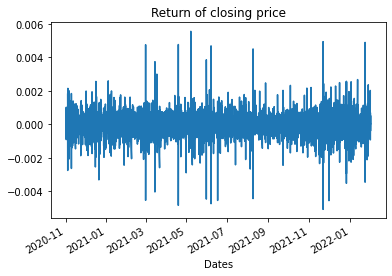

In [4]:
df[target].plot()
plt.title('Return of closing price')
plt.show()

In [5]:
lag = 128
h = 1
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, 0, dtype=dtype)

In [6]:
def LSTM_model():
    # The LSTM architecture
    act_fct = 'tanh'
    dr = 0.5
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(Flatten())
    my_LSTM_model.add(Dense(units=128, activation=act_fct))
    my_LSTM_model.add(Dense(units=1))
    return my_LSTM_model

In [7]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [8]:
def earlyStopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
if not os.path.exists('Benchmark/trained_models'):
    os.mkdir('Benchmark/trained_models')
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    'Benchmark/trained_models/%s____{epoch:04}.hdf5'%name,
    monitor='val_loss',
    save_best_only=False,
    verbose=1
)
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    elif epoch < 50:
        return 0.0001
    elif epoch < 100:
        return 0.00001
    else:
        return 0.000001

In [ ]:
from tensorflow.keras.optimizers import Adam
my_LSTM_model = LSTM_model()
my_LSTM_model.compile(
    optimizer=Adam(learning_rate=0.05),
    loss='mean_squared_error',
    metrics=[MAE, MAPE]
)

history = my_LSTM_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=True,
    callbacks=[
#         earlyStopping(),
        LearningRateScheduler(learning_rate_scheduler),
        model_checkpoints,
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

Epoch 1/100
1210/1210 [==============================] - 37s 27ms/step - loss: 1.2215 - mean_absolute_error: 0.7265 - mean_absolute_percentage_error: 5971.5513 - val_loss: 1.4008 - val_mean_absolute_error: 0.7428 - val_mean_absolute_percentage_error: 1035.4312

Epoch 00001: saving model to Benchmark/trained_models/LSTM_univariate2_EURUSD____0001.hdf5
Epoch 2/100
1210/1210 [==============================] - 32s 27ms/step - loss: 1.0098 - mean_absolute_error: 0.6586 - mean_absolute_percentage_error: 2487.5369 - val_loss: 1.3963 - val_mean_absolute_error: 0.7428 - val_mean_absolute_percentage_error: 1002.9666

Epoch 00002: saving model to Benchmark/trained_models/LSTM_univariate2_EURUSD____0002.hdf5
Epoch 3/100
1210/1210 [==============================] - 32s 27ms/step - loss: 1.0114 - mean_absolute_error: 0.6594 - mean_absolute_percentage_error: 2475.6340 - val_loss: 1.4017 - val_mean_absolute_error: 0.7433 - val_mean_absolute_percentage_error: 1220.3607

Epoch 00003: saving model to Ben

In [ ]:
history = my_LSTM_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=True,
    callbacks=[
        # earlyStopping(),
        LearningRateScheduler(learning_rate_scheduler),
        model_checkpoints,
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

In [ ]:
import pickle
with open(f'Benchmark/trained_models/{name}____history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
if 'my_LSTM_model' not in globals():
    model_last = sorted([i for i in os.listdir('Benchmark/trained_models/') if name in i and 'hdf5' in i])[-1]
    my_LSTM_model = tf.keras.models.load_model(
        os.path.join('Benchmark/trained_models', model_last)
    )
if 'history' not in globals():
    with open(f'Benchmark/trained_models/{name}____history.pkl', 'rb') as f:
        history = pickle.load(f)
if hasattr(history, 'history'):
    history = history.history

In [ ]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(history['mean_absolute_error'], label='train')
plt.plot(history['val_mean_absolute_error'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(history['mean_absolute_percentage_error'], label='train')
plt.plot(history['val_mean_absolute_percentage_error'], label='test')
plt.legend()
plt.show()

In [ ]:
my_LSTM_model.summary()
my_LSTM_model.layers[1].get_weights()[2].dtype

In [ ]:
# opt_learn_rate_plot(
#     my_LSTM_model,
#     X_train,
#     y_train,
#     10**-6,
#     10**-2,
#     100,
#     batch_size=64,
#     steps_per_epoch=1
# )

In [ ]:
LSTM_prediction = predictions(
    my_LSTM_model,
    X_test,
    sc_target
)
actual_pred_plot(LSTM_prediction[:, 0], sc_target.inverse_transform(y_test)[:, 0])
plt.show()

print('Test')
y = sc_target.inverse_transform(y_test)
# y = y_test
y_pred = LSTM_prediction = predictions(
    my_LSTM_model,
    X_test,
    sc_target
)
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

In [ ]:
print('Train')
y = sc_target.inverse_transform(y_train)
y_pred = predictions(
    my_LSTM_model,
    X_train,
    sc_target
)
actual_pred_plot(y_pred[:, 0], sc_target.inverse_transform(y_train)[:, 0])
plt.show()
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

In [ ]:
# # actual_pred_plot((LSTM_prediction- LSTM_prediction[:, 0].mean()) * 150, y_test, error=True)
# # (((LSTM_prediction[:, 0] - LSTM_prediction[:, 0].mean()) * 150 - y_test[:, 0])**2).mean()
# # plt.show()

# def LSTM_model_regularization(X_train, y_train, X_test, sc):
#     # create a model
#     from keras.models import Sequential
#     from keras.layers import Dense, SimpleRNN, GRU, LSTM
#     from keras.optimizers import SGD
    
#     # The LSTM architecture
#     my_LSTM_model = Sequential()
#     my_LSTM_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
#     #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#     #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#     my_LSTM_model.add(LSTM(units=50, activation='tanh'))
#     my_LSTM_model.add(Dense(units=2))

#     return my_LSTM_model

# # df.iloc[:, target_column].plot()
# # plt.show()

# # for i in range(1, 2):
# #     plt.scatter(
# #         df.iloc[:-i, target_column],
# #         df.iloc[i:, target_column]
# #     )
# # plt.xlabel('y_{t-1}')
# # plt.ylabel('y_t')
# # plt.show()

In [ ]:
def mde_truncated_y(y, y_pred):
    res = []
    hs_max = sorted(abs(y.flatten()), reverse=True)[0]
    hs = np.arange(0, hs_max, hs_max / 500)
    for h in hs:
        idx = abs(y) >= h
        res.append(mde(y[idx].flatten(), y_pred[idx].flatten()))
    return hs, res
def mde_truncated_y_pred(y, y_pred):
    res = []
    hs_max = sorted(abs(y.flatten()), reverse=True)[0]
    hs = np.arange(0, hs_max, hs_max / 500)
    for h in hs:
        idx = abs(y_pred) >= h
        res.append(mde(y[idx].flatten(), y_pred[idx].flatten()))
    return hs, res
# def mde_truncated_both(y, y_pred):
#     res = []
#     hs_max = sorted(abs(y.flatten()), reverse=True)[0]
#     hs = np.arange(0, hs_max, hs_max / 500)
#     for h in hs:
#         idx = np.logical_and(abs(y_pred) >= h, abs(y) >= h)
#         res.append(mde(y[idx].flatten(), y_pred[idx].flatten()))
#     return hs, res

In [ ]:
x, mdes = mde_truncated_y(y, y_pred)
plt.plot(x, mdes)
plt.xlabel('truncation h')
plt.ylabel('MDE for data |y| >= h')
plt.show()

In [ ]:
x, mdes = mde_truncated_y_pred(y, y_pred)
plt.plot(x, mdes)
plt.xlabel('truncation h')
plt.ylabel('MDE for data |y_pred| >= h')
plt.show()